In [10]:
# Импортируем все необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import r2_score
from scipy.special import softmax

In [11]:
# Загружаем датасеты
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,PATIENT_SEX,MKB_CODE,ADRES,AGE_CATEGORY,PATIENT_ID_COUNT,MONTH,YEAR,SEASON,MKB_GROUP,ZONE
0,0,A00.0,Гурьевск,young,1,8,21,3,0,0
1,0,A00.0,Калининград,children,1,3,2,2,0,0
2,0,A00.0,Гусев,children,1,3,19,2,0,1
3,0,A00.0,Калининград,children,1,1,22,1,0,0
4,0,A00.0,Калининград,children,1,2,18,1,0,0


In [12]:
# Разделяем заболевания на группы;
# При недостатке строк в какой-то из групп добавляем
# В него похожие заболевания
def separate_diseases(base, min_rows_per_code=10):
    mkb_groups = []

    for i in range(base['MKB_GROUP'].max() + 1):
        mkb_groups.append(
            base[base['MKB_GROUP'] == i].reset_index(drop=True))

    diseases = {}

    for dataset in tqdm(mkb_groups):
        codes = dataset['MKB_CODE'].value_counts()

        for code in codes.index:
            count = codes[code]
            to_select = (dataset['MKB_CODE'] == code).reset_index(drop=True)

            if (sum := to_select.sum()) < min_rows_per_code:
                addit_count = 2 * (min_rows_per_code - sum)
                addit = np.where(~to_select)[0][:addit_count]
                to_select[addit] = ~to_select[addit]
            
            diseases[code] = dataset[to_select].reset_index(drop=True)

    return diseases

In [13]:
diseases = separate_diseases(df_train)

100%|██████████| 21/21 [00:50<00:00,  2.43s/it]


In [1]:
# Менеджер трендов.
# Вот пример его работы:
# В 2019 году в среднем было в 1.5 раза
# больше больных чем в 2018;
# Тогда P2018 = P2019 / 1.5
# А если с параметром smoothing (S):
# P2018 = ~ P2019 / 1.5 * (1 - S) + S * P2018
class TimeMeanManager:
    # Конструктор
    def __init__(self, sep_by=['MKB_CODE'], stats=None, smoothing=0.25):
        if 'YEAR' in sep_by:
            sep_by = sep_by.copy()
            sep_by.remove('YEAR')
        if not (0 <= smoothing <= 1):
            raise Exception('Forbidden value for smoothing.')
        self.sep_by = sep_by
        self.smoothing = smoothing
        if stats is not None:
            self.stats = stats

    # Метод для создания "табличек" к группам
    def _create_label(self, params):
        if type(params) not in [list, tuple]:
            return str(params)
        return '&'.join([
            str(p) for p in params
        ])

    # Метод обучения
    def fit(self, df):
        df = df[(df['MONTH'] <= 4) & (df['MONTH'] >= 1)]
        grouped = df.filter(['PATIENT_ID_COUNT', 'YEAR'] + self.sep_by)
        grouped = grouped.groupby(self.sep_by)
        unique_years = sorted(df['YEAR'].unique())
        
        self.stats = {}

        for key in tqdm(grouped.groups.keys()):
            label = self._create_label(key)
            group = grouped.get_group(key)
            stat = group.groupby('YEAR').mean()
            stat = stat['PATIENT_ID_COUNT'].to_dict()

            prev = None
            for i, yr in enumerate(unique_years):
                if yr in stat:
                    prev = yr
                    continue
                post = None
                for j in range(i + 1, len(unique_years)):
                    if unique_years[j] not in stat:
                        continue
                    val = stat[unique_years[j]]
                    post = val
                    break
                arr = [i for i in [prev, post] if i is not None]
                stat[yr] = sum(arr) / len(arr)
            self.stats[label] = stat

        return self

    # Метод предсказания
    def predict(self, row):
        year = row['YEAR']
        target = row['PATIENT_ID_COUNT']
        sep_vals = list(row.filter(self.sep_by).values)
        label = self._create_label(sep_vals)
        if label not in self.stats:
            return target
        stat = self.stats[label]
        coef = stat[22] / stat[year]
        if coef == 1:
            return target
        transformed = target * coef
        return round(transformed * (1 - self.smoothing) + self.smoothing * target)

In [14]:
# Создаём менеджер трендов
manager = TimeMeanManager(sep_by=['MKB_CODE', 'ADRES'], smoothing=0.95).fit(df_train)

100%|██████████| 95311/95311 [01:29<00:00, 1062.45it/s]


In [15]:
df_train.columns

Index(['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY', 'PATIENT_ID_COUNT',
       'MONTH', 'YEAR', 'SEASON', 'MKB_GROUP', 'ZONE'],
      dtype='object')

In [16]:
# Веса для определения важности категориальных
# переменных.
# (Например, пол пациента не так 
# важен как его возрастная группа)
diff_cat_weights = {
    'PATIENT_SEX': 0.2,
    'MKB_CODE': 2,
    'ADRES': 2,
    'AGE_CATEGORY': 1.5,
    'MONTH': 1,
    'YEAR': 1.5,
    'SEASON': 0.5
}

# Фильтровая единица
class PredUnit:
    # Метод отделения
    # (Отбрасывает непохожие строки)
    def forward(self, row, df):
        return np.ones((len(df),))

    # Метод восстановления
    # (Набирает некоторые наиболее подходящие строки назад)
    def on_row_lack(self, row, df, lack):
        return []

# Модель
class ComplexPredictionModel:
    # Конструктор
    def __init__(self, base, pred_units, time_manager=None, selecting_method='mean', distance='standard', alpha=10):
        # Самостоятельное распределение болезней,
        # если необходимо
        if type(base) == pd.DataFrame:
            self.diseases = separate_diseases(base)
        elif type(base) == dict:
            self.diseases = base
        else:
            raise Exception(
                'Input data must be dataframe'
                ' or array of diseases.')
        # Предупреждение о некорректном использовании модели
        if time_manager is not None and selecting_method != 'most_similar':
            print('Warning: time manager is useful '
            'only if selecting method is "most_similar"')
        # Сохранение параметров
        self.alpha = alpha
        self.pred_units = pred_units
        self.selecting_method = selecting_method
        self.time_manager = time_manager
        self.distance = distance

    # Метод для нахождения группы болезни по
    # МКБ-коду
    def find_mkb_for_group(self, group):
        for i, df in self.diseases.items():
            if df['MKB_GROUP'][0] != group:
                continue
            return df['MKB_CODE'].mode().iloc[0]

    # Расстояние между строками в таблице
    def _get_row_distance(self, main, sub):
        distance = 0
        # Два способа измерения дистанции
        if self.distance == 'standard':
            for col in main.index:
                if type(main[col]) == str:
                    distance += int(main[col] != sub[col])
                else:
                    distance += abs(main[col] - sub[col])
        elif self.distance == 'weighted':
            for k, w in diff_cat_weights.items():
                distance += int(main[k] != sub[k]) * w
        else:
            raise Exception('Unknown distance type')
        return distance

    # Предсказание значения для строки
    def _predict_row(self, row):
        # Нахождение нужной группы болезней
        mkb_code = row['MKB_CODE']
        if mkb_code not in self.diseases:
            mkb_code = self.find_mkb_for_group(row['MKB_GROUP'])
        df = self.diseases[mkb_code]
        
        # Прохождение по всем фильтровым единицам модели;
        # В итоге остаются только самые похожие на ROW строки;
        # Причём кол-во этих строк не меньше параметра alpha.
        for unit in self.pred_units:
            to_select = unit.forward(row, df)
            if (s := to_select.sum()) < self.alpha:
                addit = unit.on_row_lack(
                    row, df, self.alpha - s
                )
                to_select = to_select | addit
            df = df.iloc[
                np.where(to_select)[0]]
            df.reset_index(drop=True, inplace=True)

        if len(df) == 0:
            return np.nan

        # Вычисление значения согласно способу
        if self.selecting_method == 'mean':
            return np.round(df['PATIENT_ID_COUNT'].mean())
        elif self.selecting_method == 'weighted_mean':
            weights = softmax(1 - softmax([
                self._get_row_distance(row, df_row) for df_row in df.iloc
            ]))
            return sum([
                val * weight for weight, val in zip(weights, df['PATIENT_ID_COUNT'])
            ])
        elif self.selecting_method == 'most_similar':
            idx = np.argmin([
                self._get_row_distance(row, df_row) for df_row in df.iloc
            ])
            row = df.iloc[idx]
            if self.time_manager is None:
                target = row['PATIENT_ID_COUNT']
            else:
                target = self.time_manager.predict(row)
            return target
        else:
            raise Exception('Unknown selecting method!')
    
    # Метод предсказания целевой переменной
    # для таблицы DataFrame
    def predict(self, df):
        pred = []
        for row in tqdm(df.iloc):
            pred.append(self._predict_row(row))
        return np.array(pred)
    
    # Метод проверки модели
    def score(self, df, y_true):
        y_pred = self.predict(df)
        return r2_score(y_true, y_pred)

In [17]:
# Фильтр возраста
class AgeUnit(PredUnit):
    def __init__(self):
        self.age_categories = [
            'children', 'young', 'elderly',
            'middleage', 'old', 'centenarians']

    def get_near_age_categories(self, cat):
        idx = self.age_categories.index(cat)
        if idx == 0:
            return [self.age_categories[1]]
        elif idx + 1 == len(self.age_categories):
            return [self.age_categories[idx - 1]]
        return [self.age_categories[idx - 1], self.age_categories[idx + 1]]
    
    def forward(self, row, df):
        return df['AGE_CATEGORY'] == row['AGE_CATEGORY']

    def on_row_lack(self, row, df, lack):
        similar = self.get_near_age_categories(row['AGE_CATEGORY'])
        return df['AGE_CATEGORY'].isin(similar)

In [18]:
# Фильтр места
class AddressUnit(PredUnit):
    def forward(self, row, df):
        return df['ADRES'] == row['ADRES']

    def on_row_lack(self, row, df, lack):
        #addit = (df['ZONE'] == row['ZONE']) & (df['ADRES'] != row['ADRES'])
        #
        #if addit.sum() >= lack:
        #    return addit
        #return np.ones((len(df),))
        return np.zeros((len(df),))

In [19]:
# Фильтр сезона
class SeasonUnit(PredUnit):
    def forward(self, row, df):
        return df['MONTH'] == row['MONTH']

    def on_row_lack(self, row, df, lack):
        addit = (df['SEASON'] == row['SEASON']) & (df['MONTH'] != row['MONTH'])
        if addit.sum() >= lack:
            return addit
        return np.ones((len(df),))

In [20]:
# Фильтр года
class YearUnit(PredUnit):
    def forward(self, row, df):
        return df['YEAR'] == row['YEAR']

    def on_row_lack(self, row, df, lack):
        absolute = np.abs(df['YEAR'] - row['YEAR'])
        return (absolute > 0) & (absolute <= 3)

In [21]:
# Фильтр пола
class SexUnit(PredUnit):
    def forward(self, row, df):
        return df['PATIENT_SEX'] == row['PATIENT_SEX']

    def on_row_lack(self, row, df, lack):
        return np.ones((len(df),))

In [22]:
# Конструирование модели
model = ComplexPredictionModel(diseases, [
    AgeUnit(),
    AddressUnit(),
    YearUnit(),
    SeasonUnit(),
    SexUnit()
], alpha=6, selecting_method='most_similar', 
    distance='standard', time_manager=manager)

In [23]:
# Проверка модели
model.score(df_train.iloc[:1000], df_train['PATIENT_ID_COUNT'][:1000])

1000it [00:03, 257.07it/s]


0.951970268385297

In [24]:
# Практически правельные результаты

In [25]:
# Предсказание на тестовом датасете
pred = model.predict(df_test)

39373it [02:41, 243.65it/s]


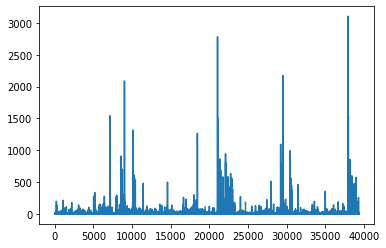

In [26]:
# Просто просмотр графика предсказаний
plt.plot(pred)

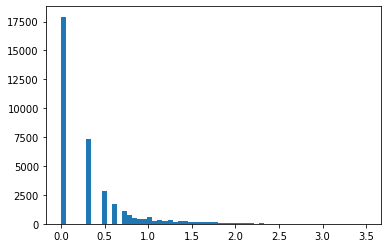

In [27]:
# Немного статистики
plt.hist(np.log10(pred), bins=60)
plt.show()

In [28]:
# Открытие уже готовой таблицы submission
subm = pd.read_csv('sample_solution.csv', sep=';', dtype={'VISIT_MONTH_YEAR': str})
subm.head()

,PATIENT_SEX,MKB_CODE,ADRES,VISIT_MONTH_YEAR,AGE_CATEGORY,PATIENT_ID_COUNT
0,0,A00,Калининград,04.22,children,0
1,0,A00,Калининград,04.22,elderly,2
2,0,A00,Калининград,04.22,middleage,3
3,0,A00,Калининград,04.22,young,1
4,0,A01,Калининград,04.22,middleage,0


In [29]:
# Замена значений и заполнение модой
subm['PATIENT_ID_COUNT'] = pred
subm['PATIENT_ID_COUNT'].fillna(
    subm['PATIENT_ID_COUNT'].mode()[0],
    inplace=True)

In [30]:
# Смена формата
subm['PATIENT_ID_COUNT'] = subm['PATIENT_ID_COUNT'].astype('int32')

In [31]:
# Сохранение
subm.to_csv('submission1.csv', index=False, sep=';')